## Introduction

This month Model Fitness lost 26.5% of its customers. 
If we don't balance out this share by acquiring new customers, the company will become less profitable. 
As such, it is a no-brainer to develop strategies to prevent customer churn as well as possible. The very first step in this endeavour is to single out the warning-signs that a customer will be lost. 

A straightforward approach to solve problems like this is using modern Machine Learning techniques. In this report, I will guide the reader through the development of a classification-model that enables Model Fitness to predict the probability of a customer to churn in the upcoming month. In a next step, I will divide our customers into five clusters which will allow us to develop group-based countermeasures based on the customers' specific risk-profiles. Finally, I will present a set of possible actions that can be taken to reduce customer churn to a minimimum. 

## Download the data

Let's have a look at the dataset, we're dealing with. This is done by calling the info method and looking at head and tail of the data. 

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
from matplotlib import pyplot as plt 
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import sys 
import warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
try:
    churn_data= pd.read_csv('gym_churn_us.csv')
except:
    churn_data= pd.read_csv('/datasets/gym_churn_us.csv')
    
display(churn_data.info())
display(churn_data.head())
display(churn_data.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0
3999,1,0,1,0,0,12,1,30,178.861814,12.0,1,1.101832,1.035270,0


It seems that there's no missing values and all columns are there as needed. 

## Preprocessing and EDA 

#### Look at the dataset: does it contain any missing features? Study the mean values and standard deviation (use the describe() method).

We already saw that we have no missing values but from above, we know that we're going to have to change the datatypes of some columns to int8. It also makes sense to check if we have duplicates in the dataset. 

In [2]:
cols= churn_data.columns[churn_data.columns.str.startswith('Avg')== False]

print(len(churn_data[churn_data.duplicated()])

churn_data[cols]= churn_data[cols].astype('int8')


churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int8   
 1   Near_Location                      4000 non-null   int8   
 2   Partner                            4000 non-null   int8   
 3   Promo_friends                      4000 non-null   int8   
 4   Phone                              4000 non-null   int8   
 5   Contract_period                    4000 non-null   int8   
 6   Group_visits                       4000 non-null   int8   
 7   Age                                4000 non-null   int8   
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   int8   
 10  Lifetime                           4000 non-null   int8   
 11  Avg_class_frequency_total          4000 non-null   float

Now, we're going to call the describe method to get an idea basic of the distribution of the columns. For the dummy variables the mean can be considered the share of the positive class. 

In [3]:
churn_data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Concerning the binary variables, we can see that gender, partner are quite balanced. All the others are quite biased towards either the positive or negative class. This applies in particular to the share of persons who left their phone number which amounts to 90 %. Most interestingly, the share of customers in the dataset who churned is 26.5%. 

Regarding the numerical features, we can see that for most variables mean and median are not far apart from each other which suggests that outliers (if present) do not impact the mean too much. The mean/stdev ratio is below 1 for most variables suggesting that the data is not overly dispersed. One exception is Lifetime. Moreover, if we look at this column's max value, we can see that it's more than 5 stdev from the mean value, which suggests a relatively skewed distribution. 

#### Look at the mean feature values in two groups: for those who left (churn) and for those who stayed (use the groupby() method).

Here, we'd like to know whether the means of different variables differ between churned and non-churned users. This will give us a first indication of the risk-factors for customer churn. 

In [4]:
churn_grouped= churn_data.groupby('Churn').mean().reset_index()
churn_grouped

,Churn,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


The differences between both groups are easy to spot. 
As we can see, on average, non-churners **live nearer** to the studio, are **more often referred** by partner companies or promo friends, tend to **sign up for longer contracts**, are more likely to **take part in group sessions** are **older**, leave **more money** in the gym, have a **longer remaining contract period**, have been with the **gym for a longer period of time**, and **visit the gym far more often** than the customers who churned. 

#### Plot bar histograms and feature distributions for those who left (churn) and those who stayed.

Let's now have a more visual look at the differences between both groups' feature distributions. 

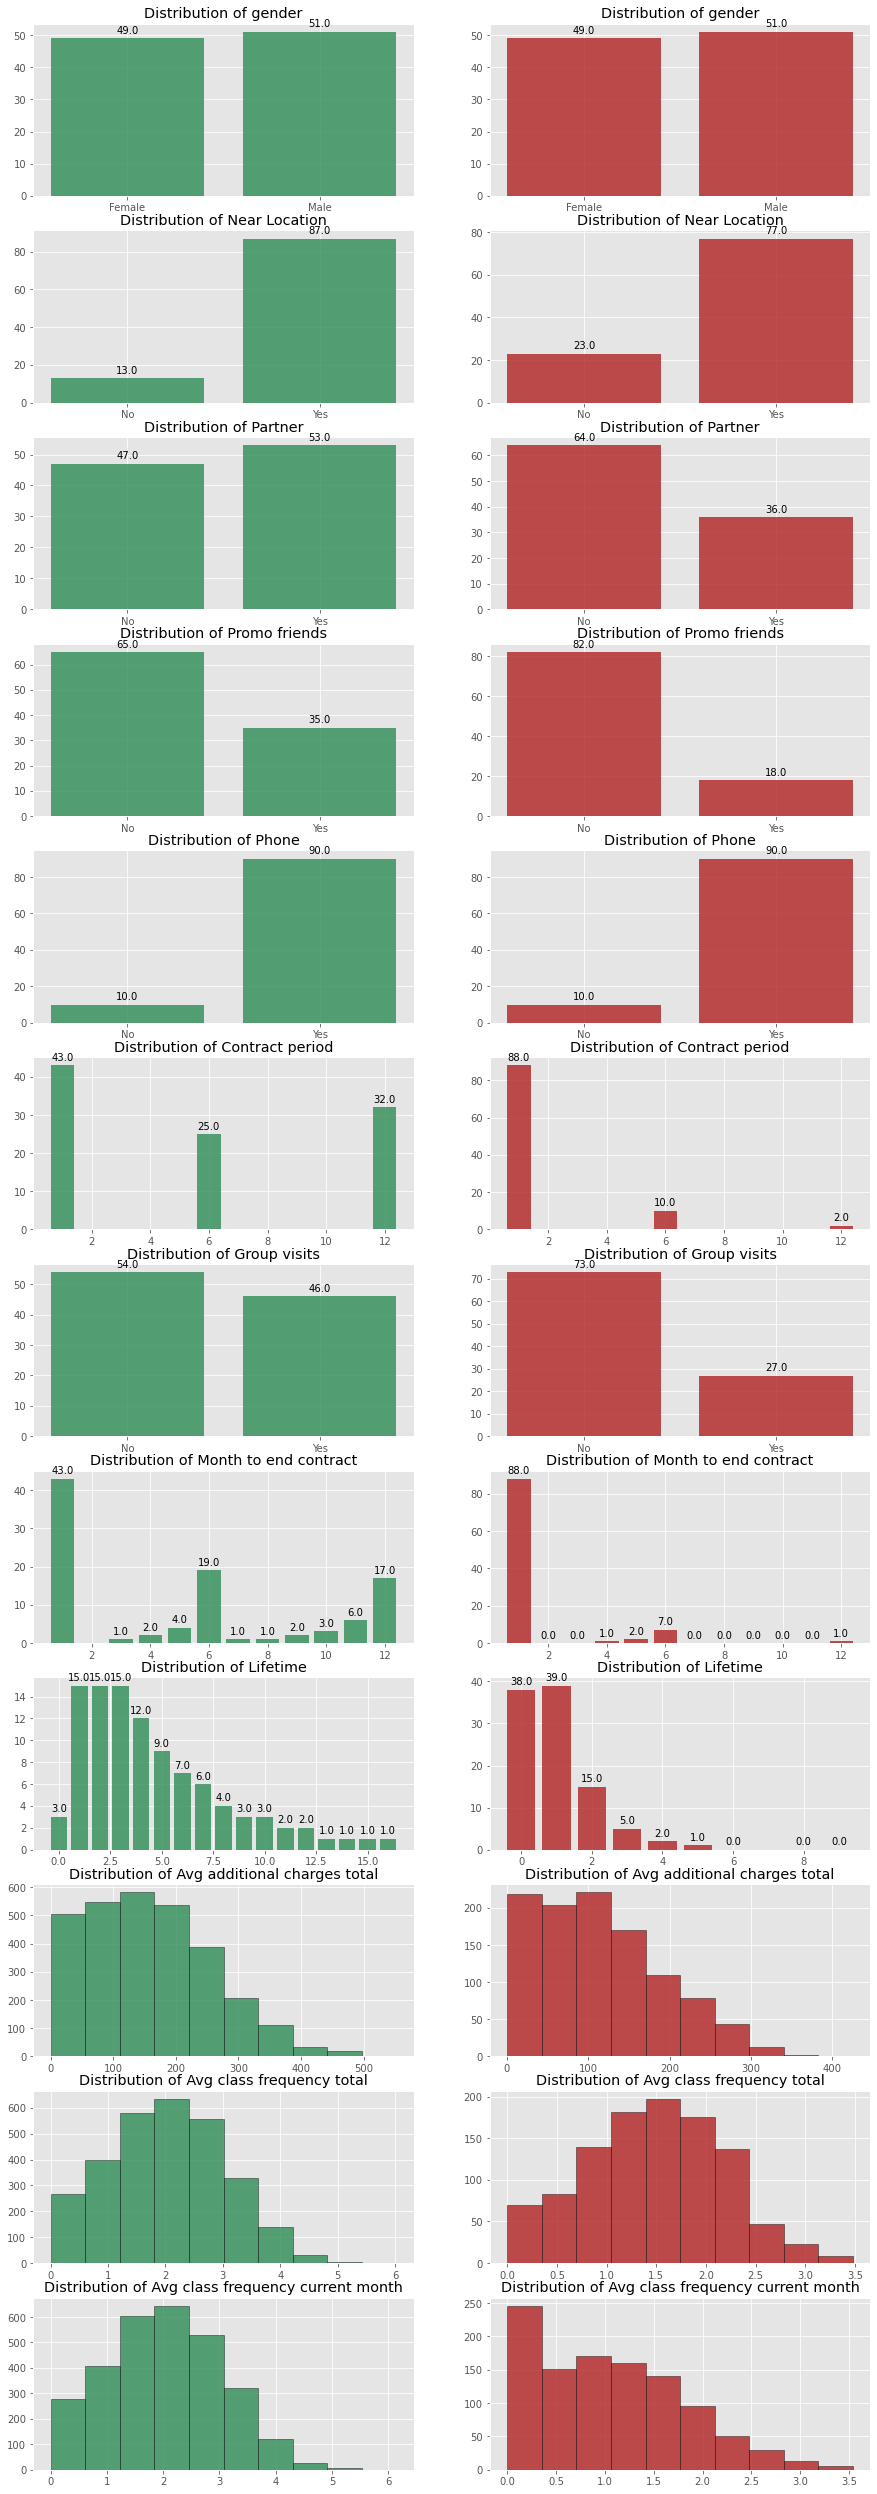

In [5]:
plt.style.use('ggplot')
non_churners= churn_data.query('Churn == 0')
churners= churn_data.query('Churn== 1')
Lifetime= sorted(list(churners.Lifetime.unique()))
Contract_period= sorted(list(churners.Contract_period.unique()))
Month_to_end_contract= sorted(list(churners.Month_to_end_contract.unique()))
cols= cols[cols!= 'Age']
floats= list(churners.select_dtypes(include=[np.float]).columns)

dummy_dict= {'gender': ['Female','Male'],
            'Near_Location': ['No','Yes'],
            'Partner': ['No','Yes'],
            'Promo_friends': ['No','Yes'],
            'Phone': ['No','Yes'],
            'Contract_period': Contract_period,
            'Group_visits': ['No','Yes'],
            'Month_to_end_contract': Month_to_end_contract,
             'Lifetime':Lifetime,
            'Churn':['No','Yes']}

def autolabel(rects,p,s):
    for rect in rects:
        height = rect.get_height()
        axs[p,s].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')
        
i= 0
j= 0
fig, axs = plt.subplots(12, 2, figsize=(15, 45))

for name,data in non_churners[cols[cols!='Churn']].iteritems():
    plt.style.use('ggplot')
    distr= non_churners[cols].groupby(name)['Churn'].count().reset_index().sort_values(name)
    distr['Percent']= np.round(distr['Churn']/distr['Churn'].sum()*100)
    distr= distr.query('Percent > 0')
    try:
        plot= axs[i,0].bar(dummy_dict[name], distr['Percent'], color= 'seagreen', alpha= 0.8)
    except:
        plot= axs[i,0].bar(distr[name], distr['Percent'], color= 'seagreen', alpha= 0.8)
    axs[i,0].set_title('Distribution of ' + name.replace('_',' '))
    autolabel(plot,i,0)
    i+=1
    
for name,data in churners[cols[cols!='Churn']].iteritems():
    distr= churners[cols].groupby(name)['Churn'].count().reset_index().sort_values(name)
    distr['Percent']= np.round(distr['Churn']/distr['Churn'].sum()*100)
    plot= axs[j,1].bar(dummy_dict[name], distr['Percent'], color= 'firebrick', alpha= 0.8)
    axs[j,1].set_title('Distribution of ' + name.replace('_',' '))
    autolabel(plot,j,1)
    j+=1
    
i= 9
j= 9

for name, data in non_churners[floats].iteritems():
    plot= axs[i,0].hist(data, histtype= 'bar', ec= 'black', color= 'seagreen', alpha= 0.8)
    axs[i,0].set_title('Distribution of ' + name.replace('_',' '))
    i+=1
for name, data in churners[floats].iteritems():
    plot= axs[j,1].hist(data,histtype= 'bar', ec= 'black', color= 'firebrick', alpha= 0.8)
    axs[j,1].set_title('Distribution of ' + name.replace('_',' '))
    j+=1
    

#### Build a correlation matrix and display it.

Here, we're going to build a pearson correlation matrix of all features. This will be done for both, categorical and numerical features. While the interpretation of correlations with categorical features shouldn't be taken at face value (especially for multiclass features such as contract period), the coefficients can help us interpret the strength of association between the variables. Beyond helping us to find risk-factors , it will also help us identify sources of multicollinearity which can affect the performance of the subsequent model.

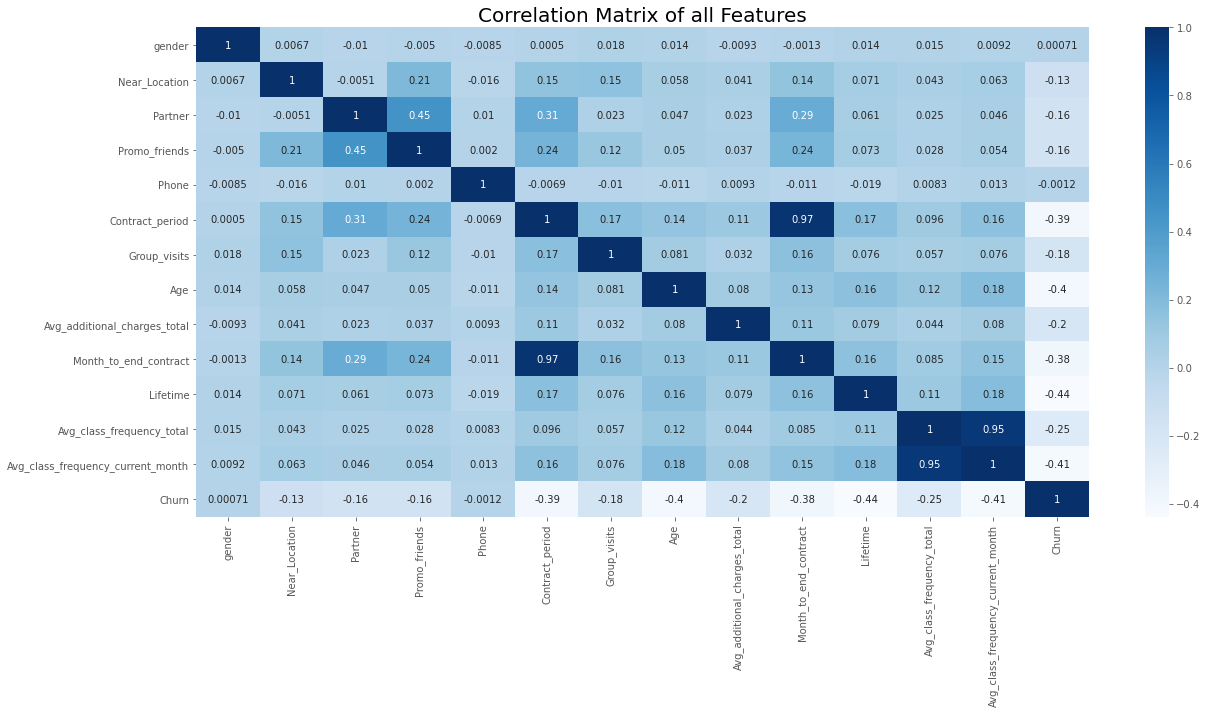

In [74]:
fig, ax= plt.subplots(figsize = (20,9))
sns.heatmap(churn_data.corr(), annot= True,cmap= 'Blues')
ax.set_title('Correlation Matrix of all Features', size= 20)
plt.show()

We can see that Month_to_end_contract and contract_period have an almost perfect positive correlation. This does not come as a surprise but shouldn't be overinterpreted given that we are correlating a quasi-continuous variable with an ordered quasi-categorical variable. In the later model we might test if we get better performance when removing one of the variables. Moreover, the class frequencies are also highly correlated.

## Additional Step: Creating new features

Another promising thing to do before delving into the model-building is to craft additional features. One approach is to search for interaction effects of different variables. To find interactions, I will compute the correlation coefficient of all possible multiplied variable-pairs with churn. If one turns out higher than the correlation of both component variables, I will add the feature to the dataset.  

In [69]:
kurz= []

for name, column in churn_data.drop('Churn',axis=1).iteritems():
    for thing, data in churn_data.drop('Churn',axis=1).iteritems():
        if thing != name:
            interaction= churn_data[name]*churn_data[thing]
            combination= name, ' and ', thing
            kurz.append({'combination':combination, 'value': pearsonr(interaction, churn_data['Churn'])[0]})

pd.DataFrame(kurz).sort_values('value', ascending= True).head(10)

,combination,value
151,"(Avg_class_frequency_current_month, and , Age)",-0.445220
95,"(Age, and , Avg_class_frequency_current_month)",-0.445220
154,"(Avg_class_frequency_current_month, and , Lif...",-0.410705
131,"(Lifetime, and , Avg_class_frequency_current_...",-0.410705
57,"(Phone, and , Lifetime)",-0.397653
124,"(Lifetime, and , Phone)",-0.397653
21,"(Near_Location, and , Lifetime)",-0.396680
121,"(Lifetime, and , Near_Location)",-0.396680
130,"(Lifetime, and , Avg_class_frequency_total)",-0.391076
142,"(Avg_class_frequency_total, and , Lifetime)",-0.391076


As we can see, average_class_frequency_current_month and age produce a higher negative correlation together than both features in isolation (-0.445 vs -0.41 and -0.4 respectively). Thus, I will later test if the inclusion of this feature results in a performance improvement.  

Another idea I had was to create a feature that considers if a customer was 'under-' or  'overvisiting' the studio in the last month with regards to his/her total average of visits. If someone visits the gym less frequently than typically, this could be a warning sign that we're going to lose this customer very soon. A metric to capture this behaviour would simply be the ratio of ````Avg_class_frequency_current_month```` and ````Avg_class_frequency_total````. 
The evaluation metric in this case would again be the correlation coefficient. If the new variable results in a higher coefficient than its components, I will test whether its inclusion improves the model. 

In [75]:
interaction= churn_data['Avg_class_frequency_current_month']/churn_data['Avg_class_frequency_total']


nulls= list(interaction[np.isfinite(interaction)== False].index)

number1= interaction.drop(nulls,axis= 0)
number2= churn_data['Churn'].drop(nulls, axis= 0)

pearsonr(number1, number2)

(-0.48169517660744887, 1.863952234702951e-226)

The new metric has a moderately higher correlation than both its components (-0.48 vs. -0.41 and -0.25). 

We might further tweak it, if we consider that the ratio might be less representative for long-term members as compared to someone who signed up only a few weeks ago. We can introduce a weight based on the lifetime of a customer to correct for this fact. As such, I will multiply the ratio with the square-root of the customers lifetime. The square-root is used to not overestimate the impact of the lifetime. 

In [76]:
interaction= churn_data['Avg_class_frequency_current_month']/churn_data['Avg_class_frequency_total']*np.sqrt(churn_data['Lifetime'])


nulls= list(interaction[np.isfinite(interaction)== False].index)

number1= interaction.drop(nulls,axis= 0)
number2= churn_data['Churn'].drop(nulls, axis= 0)

pearsonr(number1, number2)

(-0.6143530291396705, 0.0)

The lifetime weight resulted in an enormous improvement of the correlation coefficient (-0.61 compared to -0.48 of the unweighted metric). Thus, the impact of this feature on overall model performance will be tested as well. 

## Build a model to predict user churn

##### Comparing Models with different feature combinations

In this part, I'm going to fit a classification model to predict customer churn. The two methods to be compared are Logistic Regression and Random Forests. As instructed, the metrics chosen to evaluate model performance are accuracy, recall and precision. I'm also going to include F1-score which is the harmonic mean of recall and precision. Maximising F1 should thus result in optimal values for these two metrics. As a side note, I believe that recall should be the most important metric for our business problem. It represents the share of correctly identified churns from all churns in the sample. Thus it evaluates the model's ability to capture all relevant cases. Precision on the other hand measures how often the model is correct if it identifies a positive case. I believe that we should be more worried about recall and tolerate lower rates of precision since a lost customer will be more expensive than the investment made to keep a customer who would have stayed anyways. While these are just general considerations, I will try to maximise all three metrics at the same time. 

In the first step, I will compare the two algorithms with different feature combinations. The three variables created in the last section will be added in all possible combinations and the models with the best scores will be chosen for further improvement. The train-test split is 80/20. 

In [79]:
start= '\033[1m'
end= '\033[0;0m'

def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_true= y_test
    accuracy= accuracy_score(y_true, y_pred)
    precision= precision_score(y_true, y_pred, average= 'binary')
    recall= recall_score(y_true, y_pred, average= 'binary')
    F1= 2*(precision*recall/(precision+recall))
    print(str(m).replace('()',''))
    print('Accuracy: ', accuracy,'\n'
          'Precision: ', precision,'\n'
          'Recall: ', recall,'\n'
         'F1-Score:', F1)
    print()
    
models = [RandomForestClassifier(random_state=1), LogisticRegression()]
    
X= churn_data.drop('Churn',axis= 1)
y= churn_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 0)

scaler = StandardScaler() 

X_train_st = scaler.fit_transform(X_train) 

X_test_st = scaler.transform(X_test)

print(start+'Accuracy, Precision and Recall without Interaction'+end)

for i in models:
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)


X['interaction']= X['Age']*X['Avg_class_frequency_current_month']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 0)

X_train_st = scaler.fit_transform(X_train) 

X_test_st = scaler.transform(X_test)
print(start +'Accuracy, Precision and Recall with Interaction 1'+end)

for i in models:
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)
    

X= churn_data.drop('Churn',axis= 1)
y= churn_data['Churn']

X['interaction2']= X['Avg_class_frequency_current_month']/X['Avg_class_frequency_total']

nulls= list(X[np.isfinite(X['interaction2'])== False].index)

X_train, X_test, y_train, y_test = train_test_split(X.drop(nulls,axis= 0),y.drop(nulls,axis= 0), test_size= 0.2, random_state= 0)

X_train_st = scaler.fit_transform(X_train) 

X_test_st = scaler.transform(X_test)
print(start+'Accuracy, Precision and Recall with Interaction 2'+end)

for i in models:
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)
    

X= churn_data.drop('Churn',axis= 1)
y= churn_data['Churn']

X['interaction3']= X['Avg_class_frequency_current_month']/X['Avg_class_frequency_total']*np.sqrt(X['Lifetime'])

nulls= list(X[np.isfinite(X['interaction3'])== False].index)

X_train, X_test, y_train, y_test = train_test_split(X.drop(nulls,axis= 0),y.drop(nulls,axis= 0), test_size= 0.2, random_state= 0)

X_train_st = scaler.fit_transform(X_train) 

X_test_st = scaler.transform(X_test)
print(start+'Accuracy, Precision and Recall with Interaction 3'+end)

for i in models:
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)



X= churn_data.drop('Churn',axis= 1)
y= churn_data['Churn']

X['interaction']= X['Age']*X['Avg_class_frequency_current_month']

X['interaction2']= X['Avg_class_frequency_current_month']/X['Avg_class_frequency_total']

nulls= list(X[np.isfinite(X['interaction2'])== False].index)

X_train, X_test, y_train, y_test = train_test_split(X.drop(nulls,axis= 0),y.drop(nulls,axis= 0), test_size= 0.2, random_state= 0)

scaler = StandardScaler() 

X_train_st = scaler.fit_transform(X_train) 

X_test_st = scaler.transform(X_test)
print(start+'Accuracy, Precision and Recall with Interaction 1 and 2'+end)

for i in models:
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)



X= churn_data.drop('Churn',axis= 1)
y= churn_data['Churn']

X['interaction']= X['Age']*X['Avg_class_frequency_current_month']

X['interaction3']= X['Avg_class_frequency_current_month']/X['Avg_class_frequency_total']*np.sqrt(X['Lifetime'])

nulls= list(X[np.isfinite(X['interaction3'])== False].index)

X_train, X_test, y_train, y_test = train_test_split(X.drop(nulls,axis= 0),y.drop(nulls,axis= 0), test_size= 0.2, random_state= 0)

scaler = StandardScaler() 

X_train_st = scaler.fit_transform(X_train) 

X_test_st = scaler.transform(X_test)
print(start+'Accuracy, Precision and Recall with Interaction 1 and 3'+end)

for i in models:
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)



X= churn_data.drop('Churn',axis= 1)
y= churn_data['Churn']


X['interaction2']= X['Avg_class_frequency_current_month']/X['Avg_class_frequency_total']

X['interaction3']= X['Avg_class_frequency_current_month']/X['Avg_class_frequency_total']*np.sqrt(X['Lifetime'])

nulls= list(X[np.isfinite(X['interaction3'])== False].index)

X_train, X_test, y_train, y_test = train_test_split(X.drop(nulls,axis= 0),y.drop(nulls,axis= 0), test_size= 0.2, random_state= 0)

scaler = StandardScaler() 

X_train_st = scaler.fit_transform(X_train) 

X_test_st = scaler.transform(X_test)
print(start+'Accuracy, Precision and Recall with Interaction 2 and 3'+end)

for i in models:
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)


X= churn_data.drop('Churn',axis= 1)
y= churn_data['Churn']

X['interaction']= X['Age']*X['Avg_class_frequency_current_month']

X['interaction2']= X['Avg_class_frequency_current_month']/X['Avg_class_frequency_total']

X['interaction3']= X['Avg_class_frequency_current_month']/X['Avg_class_frequency_total']*np.sqrt(X['Lifetime'])

nulls= list(X[np.isfinite(X['interaction3'])== False].index)

X_train, X_test, y_train, y_test = train_test_split(X.drop(nulls,axis= 0),y.drop(nulls,axis= 0), test_size= 0.2, random_state= 0)

scaler = StandardScaler() 

X_train_st = scaler.fit_transform(X_train) 

X_test_st = scaler.transform(X_test)
print(start+'Accuracy, Precision and Recall with Interaction 1, 2 and 3'+end)

for i in models:
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

Accuracy, Precision and Recall without Interaction
RandomForestClassifier(random_state=1)
Accuracy:  0.9125 
Precision:  0.8333333333333334 
Recall:  0.8080808080808081 
F1-Score: 0.8205128205128206

LogisticRegression
Accuracy:  0.9225 
Precision:  0.8541666666666666 
Recall:  0.8282828282828283 
F1-Score: 0.8410256410256411

Accuracy, Precision and Recall with Interaction 1
RandomForestClassifier(random_state=1)
Accuracy:  0.92125 
Precision:  0.8534031413612565 
Recall:  0.8232323232323232 
F1-Score: 0.8380462724935732

LogisticRegression
Accuracy:  0.9225 
Precision:  0.8541666666666666 
Recall:  0.8282828282828283 
F1-Score: 0.8410256410256411

Accuracy, Precision and Recall with Interaction 2
RandomForestClassifier(random_state=1)
Accuracy:  0.9629629629629629 
Precision:  0.9633507853403142 
Recall:  0.8932038834951457 
F1-Score: 0.9269521410579346

LogisticRegression
Accuracy:  0.9412515964240102 
Precision:  0.9 
Recall:  0.8737864077669902 
F1-Score: 0.8866995073891626

Accur

We can see that the Random Forest with 'Interactions' 1 and 2 wins the first race and achieves an Accuracy of 96.4% and F1-score of 93%. This is an absolute improvement of more than 5% in accuracy and more than 10% in F1 as compared to the 'baseline' model (The one without the new features). 

The logistic Regression has its best performance with features 2 and 3 (Accuracy of 94.38% and an F1-score of 89.1%). For further comparison, I will nevertheless include features 1 and 2. On the one hand, that's because it has the highest recall score of all logistic regressions ( which I aoverall consider the most important metric), on the other hand, the Random Forests seem to outperform the logistic regression in all metrics. 

###### Tuning model hyperparameters 

In this part, I will tune the hyperparameters of both models. For the logistic regression, I will seek to optimise the type of regularisation (L1, L2 or none), the weight of the penalisation and the solver used to minimise the model's cost function. 

For the Random Forests, I will optimise the number of trees used, the number of features considered at each split, whether and how to assign class weights and if bootstrapped samples should be used. 

The procedure to optimise the hyperparameters is a Grid Search which will search the optimal configuration of parameters. Every possible combination of parameters runs through a cross-validation procedure where the training data is split in k subsets each of which will serve as test set one time and as training set n-1 times. The cross validation will be repeated three times and the mean F1 score of each combination will be reported. The best model will then be chosen. 

The procedure is largely my interpretation of this article: https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/ 

In [91]:
X= churn_data.drop('Churn',axis= 1)
y= churn_data['Churn']

X['Age_times_frequency_current_month']= X['Age']*X['Avg_class_frequency_current_month']

X['Frequency_Ratio']= X['Avg_class_frequency_current_month']/X['Avg_class_frequency_total']

nulls= list(X[np.isfinite(X['Frequency_Ratio'])== False].index)

X_train, X_test, y_train, y_test = train_test_split(X.drop(nulls,axis= 0),y.drop(nulls,axis= 0), test_size= 0.2, random_state= 0)

scaler = StandardScaler() 

X_train_st = scaler.fit_transform(X_train) 

X_test_st = scaler.transform(X_test)

In [92]:
# Hyperparameter Tuning 

model= LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear','saga']
penalty= ['none', 'l1', 'l2', 'elasticnet']
c_values = [100,50, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train_st, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.862840 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.862618 (0.025308) with: {'C': 100, 'penalty': 'none', 'solver': 'newton-cg'}
0.862618 (0.025308) with: {'C': 100, 'penalty': 'none', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'none', 'solver': 'liblinear'}
0.859317 (0.026988) with: {'C': 100, 'penalty': 'none', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.862840 (0.025348) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.859317 (0.026988) with: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
0.862618 (0.025308) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.862618 (0.025308) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.862840 (0.025348) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.859317 (0.026988) with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.000000 (0.000000) wit

The best configuration in the example is the {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}. Note that the F1-score is lower than the first model. This is likely due to the different sizes of training and validation sets in the context of cross-validation as compared to the model above which was trained on more data. I'm still confident that these parameters will improve the model when trained on the whole training set. 

In [48]:
model = RandomForestClassifier(random_state= 15)
n_estimators = [100,200, 300,400, 500]
max_features = list(np.arange(4,7))
class_weight= ['balanced','balanced_subsample',None]
bootstrap= [True, False]
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features, class_weight= class_weight, bootstrap= bootstrap)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train_st, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

Best: 0.914383 using {'bootstrap': True, 'class_weight': None, 'max_features': 6, 'n_estimators': 500}
0.910050 (0.013234) with: {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 4, 'n_estimators': 100}
0.910059 (0.012052) with: {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 4, 'n_estimators': 200}
0.908118 (0.010278) with: {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 4, 'n_estimators': 300}
0.908401 (0.011485) with: {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 4, 'n_estimators': 400}
0.909741 (0.010729) with: {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 4, 'n_estimators': 500}
0.907946 (0.014035) with: {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 5, 'n_estimators': 100}
0.909043 (0.012539) with: {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 5, 'n_estimators': 200}
0.909472 (0.014107) with: {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 5, 'n_est

The random forests perform best with the following hyperparameters: {'bootstrap': True, 'class_weight': None, 'max_features': 6, 'n_estimators': 500}. Here we also observe a lower F1-score but I will stick with these parameters as it may likely result in model improvement. 

#### Find the optimal threshold. 

Based on our precision and recall scores, we can find optimal probability-thresholds to tell our model when to assign an observation to a certain class. If we plot precision and recall against each other, we can identify the point for which both are maximised - where F1 is maximised. 

In [85]:
LR= LogisticRegression(C= 100, penalty= 'l1', solver= 'liblinear')
LR.fit(X_train_st,y_train)


RF= RandomForestClassifier(bootstrap= True, class_weight= None, n_estimators= 500, max_features= 6,random_state= 15)
RF.fit(X_train_st,y_train)

RandomForestClassifier(max_features=6, n_estimators=500, random_state=15)

Logistic Regression
Best Threshold: 0.4634 with F-Score: 0.8932
Recall: 0.8932, Precision: 0.8932, Accuracy: 0.9425287356321839
RandomForests
Best Threshold: 0.41 with F-Score: 0.9383
Recall: 0.9223, Precision: 0.9548, Accuracy: 0.9680715197956578


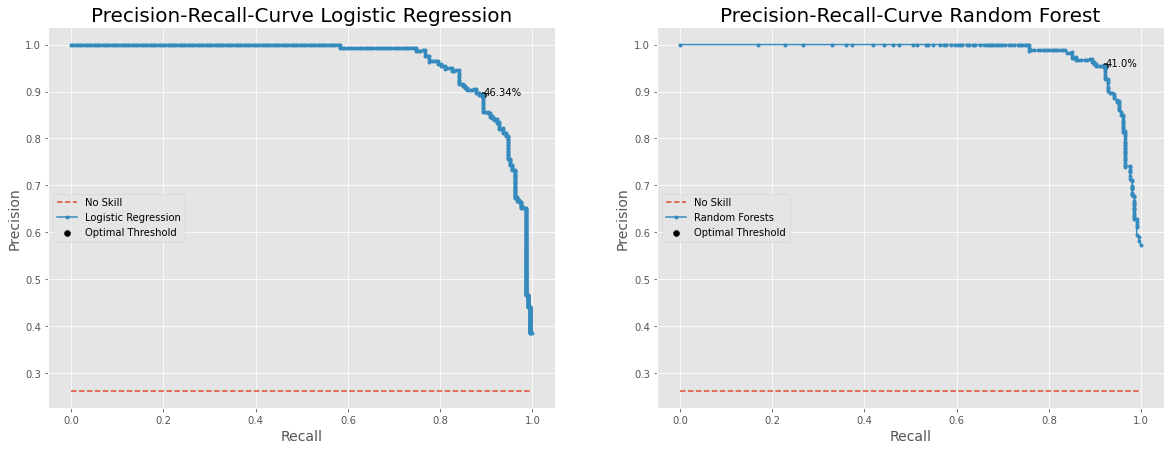

In [86]:
# Create the Precision-Recall curve

fig, ax= plt.subplots(1,2,figsize= (20,7))

probabilities= LR.predict_proba(X_test_st)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, probabilities)

fscore = (2 * precision * recall) / (precision + recall)
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
recallOpt = round(recall[index], ndigits = 4)
precisionOpt = round(precision[index], ndigits = 4)
new_preds1= [0 if x < thresholdOpt else 1 for x in probabilities]
accuracyOpt= accuracy_score(y_test, new_preds1)
print('Logistic Regression')
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}, Accuracy: {}'.format(recallOpt, precisionOpt, accuracyOpt))


no_skill = len(y_test[y_test==1]) / len(y_test)

ax[0].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
ax[0].plot(recall, precision, marker='.', label='Logistic Regression')
ax[0].scatter(recallOpt, precisionOpt,color= 'black', label= 'Optimal Threshold')
ax[0].annotate(str(np.round(thresholdOpt*100,2))+'%',(recallOpt,precisionOpt))
ax[0].set_xlabel('Recall',size= 14)
ax[0].set_ylabel('Precision',size= 14)
ax[0].set_title('Precision-Recall-Curve Logistic Regression', size= 20)
ax[0].legend()

probabilities= RF.predict_proba(X_test_st)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, probabilities)

fscore = (2 * precision * recall) / (precision + recall)
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
recallOpt = round(recall[index], ndigits = 4)
precisionOpt = round(precision[index], ndigits = 4)
new_preds2= [0 if x < thresholdOpt else 1 for x in probabilities]
accuracyOpt= accuracy_score(y_test, new_preds2)
print('RandomForests')
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}, Accuracy: {}'.format(recallOpt, precisionOpt, accuracyOpt))


no_skill = len(y_test[y_test==1]) / len(y_test)

ax[1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
ax[1].plot(recall, precision, marker='.', label='Random Forests')
ax[1].scatter(recallOpt, precisionOpt,color= 'black', label= 'Optimal Threshold')
ax[1].annotate(str(np.round(thresholdOpt*100,2))+'%',(recallOpt,precisionOpt))
ax[1].set_xlabel('Recall',size= 14)
ax[1].set_ylabel('Precision',size= 14)
ax[1].set_title('Precision-Recall-Curve Random Forest', size= 20)
ax[1].legend()

plt.show()

We see that we could further imporve our random forests F1 score from 93% to 93.83%. Accuracy improved from 96.4% to 96.8%. Most importantly recall could be increased by almost 2% while not getting a significantly worse precision. 

The logistic regression had only slight improvements after the adjustments, maintaining the same accuracy while increasing F1 by roughly 1%. However, since the Random Forest classifier seems to be the clear winner, we should not worry about this too much. 

Below, I displayed confusion matrices of both models to visualise how both models performed on the test set. 

              precision    recall  f1-score   support

 Not_Churned       0.96      0.96      0.96       577
     Churned       0.89      0.89      0.89       206

    accuracy                           0.94       783
   macro avg       0.93      0.93      0.93       783
weighted avg       0.94      0.94      0.94       783



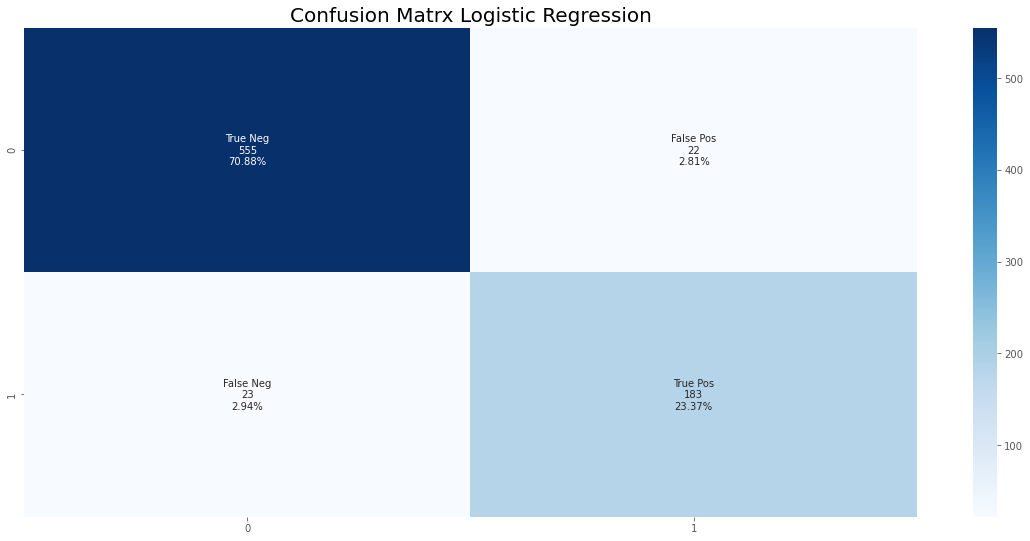

In [87]:
probabilities= LR.predict_proba(X_test_st)[:,1]

print(classification_report(y_test, new_preds1, target_names=['Not_Churned','Churned']))

fig, ax= plt.subplots(figsize= (20,9))
cf_matrix= sklearn.metrics.confusion_matrix(y_test, new_preds1)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

ax.set_title('Confusion Matrx Logistic Regression', size= 20)
plt.show()

              precision    recall  f1-score   support

 Not_Churned       0.97      0.98      0.98       577
     Churned       0.95      0.92      0.94       206

    accuracy                           0.97       783
   macro avg       0.96      0.95      0.96       783
weighted avg       0.97      0.97      0.97       783



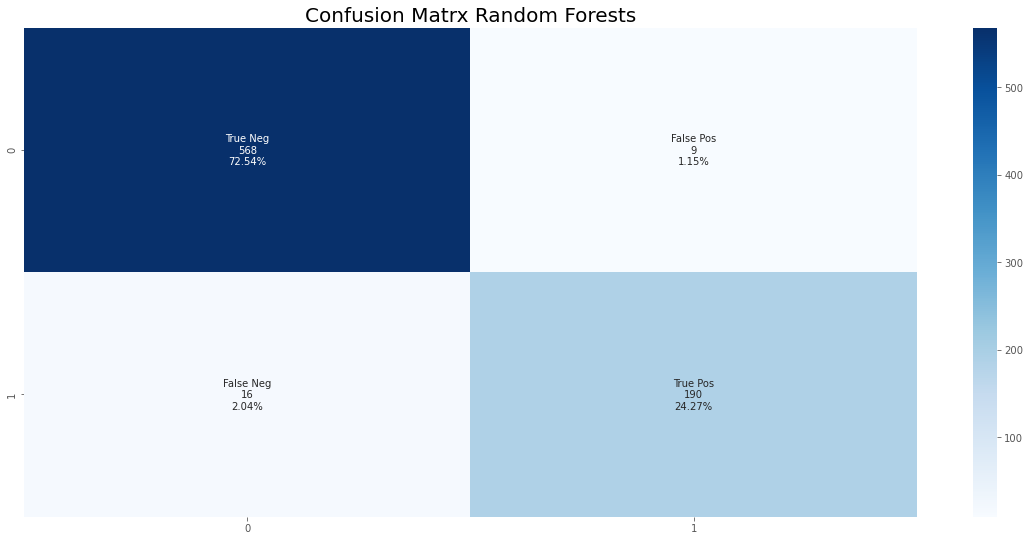

In [88]:
probabilities= RF.predict_proba(X_test_st)[:,1]

print(classification_report(y_test, new_preds2, target_names=['Not_Churned','Churned']))


fig, ax= plt.subplots(figsize= (20,9))
cf_matrix= sklearn.metrics.confusion_matrix(y_test, new_preds2)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

ax.set_title('Confusion Matrx Random Forests', size= 20)
plt.show()

#### Importance

Feature importance is very important from a business perspective. Below I plotted how features were weighted by both models. 

In [89]:
features= list(X.columns)
importance = LR.coef_[0]
LR_importance= []

for i,v in enumerate(importance):
    LR_importance.append({'feature':str(features[i]), 'weight':v})
    
importance = RF.feature_importances_
RF_importance= []

for i,v in enumerate(importance):
    RF_importance.append({'feature':str(features[i]), 'weight':v})
    
LR_importance= pd.DataFrame(LR_importance)
RF_importance= pd.DataFrame(RF_importance)

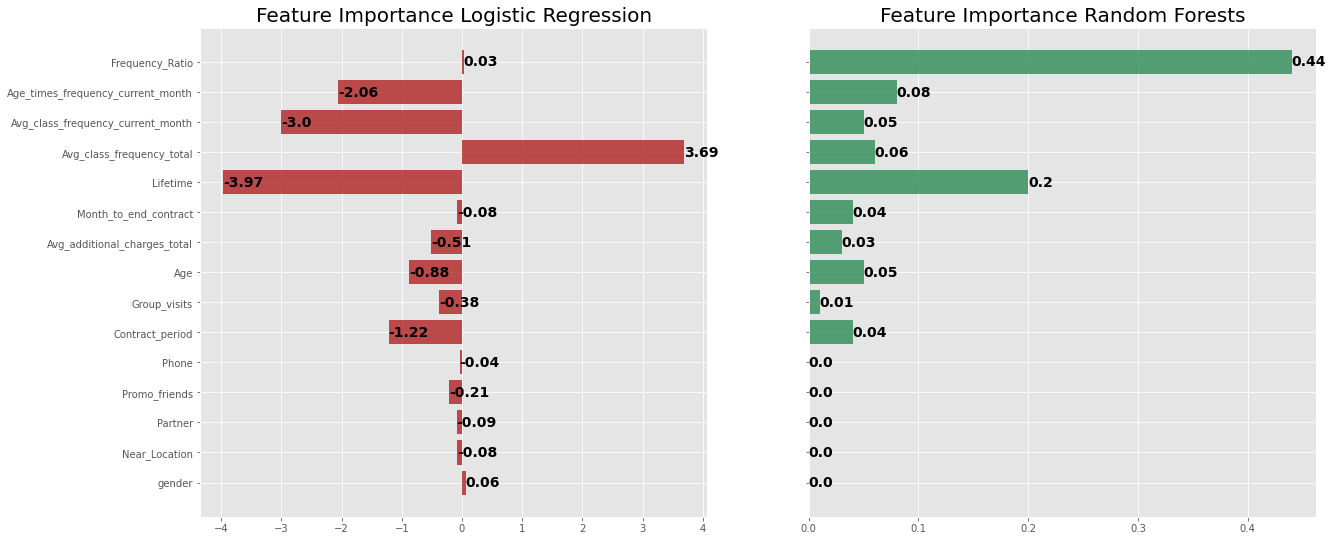

In [90]:
def autolabel(rects,p):
    for i, v in enumerate(rects):
        ax[p].text(v.get_width(), i, str(v.get_width()), color='black', fontweight='bold', fontsize=14, ha='left', va='center')

fig, ax= plt.subplots(ncols= 2, sharey= True, figsize= (20,9))

plot1= ax[0].barh(LR_importance.feature, np.round(LR_importance.weight,2), color= 'firebrick', alpha= 0.8)

ax[0].set_title('Feature Importance Logistic Regression', size= 20)


autolabel(plot1, 0)


plot2= ax[1].barh(RF_importance.feature, np.round(RF_importance.weight,2), color= 'seagreen', alpha= 0.8)

ax[1].set_title('Feature Importance Random Forests', size= 20)

autolabel(plot2, 1)

                       
    
plt.show()

We can see that the Random Forest gave the ````Frequency_Ratio```` the largest weight. The other new metric ````Age_times_class_frequency_current_month```` came out on the third spot after Lifetime. 

Interestingly, the frequency ratio had no real impact on the logistic regression. In addition, we see a strange behaviour of the coefficient sign of avg_class_frequency total which according to the model increases the likelihood for churn. Since this is clearly not the case (as shown earlier), we can assume that the coefficients are rigged by noise (strong collinearity between the class frequency variables). Since we applied penalisation, we might still assume that we were supposed to include the variables in the model like that. It might also be the case that we're seeing a suppressor effect where one variable dampens the other. Taking care of these issues is beyond the scope of this project, and perhaps not even so important since the Random Forests has performed beeter. 

All in all we have a model that performed with an acceptable level of accuracy, precision and recall and which will definitely help us to mitigate churn more effectively. 

# Create user clusters

#### Use the linkage() function to build a matrix of distances based on the standardized feature matrix and plot a dendrogram. Note: rendering the dendrogram may take time! Use the resulting graph to estimate the number of clusters you can single out.

Now, I'm going to estimate the optimal number of user clusters with a dendogram. 

In [94]:
cluster_data= churn_data.drop('Churn',axis= 1)

Z= scaler.fit_transform(cluster_data)

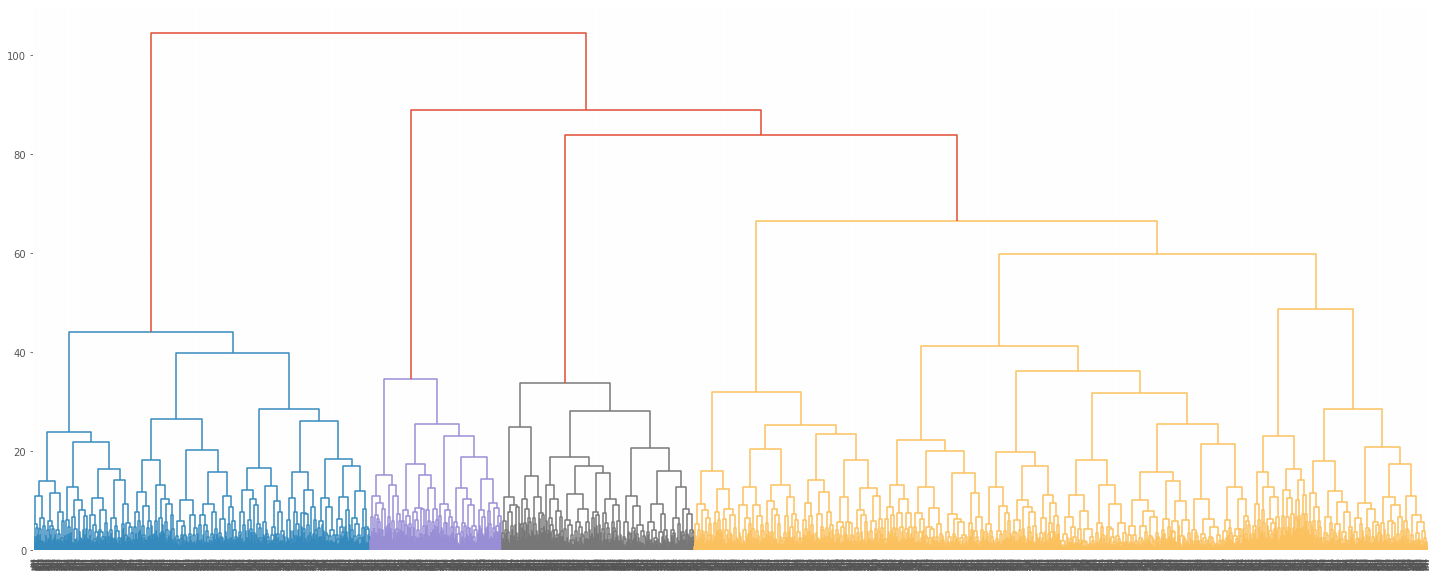

In [616]:
Z = linkage(Z, 'ward')
        
fig = plt.figure(figsize=(25, 10))

dn = dendrogram(Z)
plt.title('Hierarchical Clustering for Churn')    
plt.show()

The Dendogram above suggests that the optimal number of clusters is 4. Nevertheless the subsequently applied k-Means Algorithm will choose k= 5 as suggested in the project description. 

#### Train the clustering model with the K-means algorithm and predict customer clusters. (Let the number of clusters be n=5, so that it'll be easier to compare your results with those of other students. However, in real life, no one will give you such hints, so you'll have to decide based on the graph from the previous step.)

In [96]:

km = KMeans(n_clusters = 5)

labels= km.fit_predict(Z)

In [636]:
labels

array([3, 2, 1, ..., 2, 0, 3])

#### Look at the mean feature values for clusters. Does anything catch your eye?

In [97]:
cluster_data['cluster_km']= labels

cluster_data.groupby('cluster_km').mean().reset_index()

,cluster_km,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,0,0.489051,1.000000,0.351987,0.237632,1.0,1.966748,0.340633,28.144363,130.234172,1.875912,2.317924,1.234082,0.995237
1,1,0.501972,0.960552,0.783037,0.573964,1.0,10.887574,0.541420,29.980276,160.794855,9.948718,4.724852,1.996468,1.989661
2,2,0.552969,0.979045,0.352736,0.233993,1.0,2.571595,0.470314,30.098952,162.548581,2.371362,5.006985,2.802940,2.798145
3,3,0.496063,0.000000,0.460630,0.078740,1.0,2.375984,0.218504,28.486220,135.544499,2.222441,2.811024,1.666510,1.485248
4,4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967


Cluster number 1 has much higher mean values for almost every feature. Cluster number 0 on the other hand consistently has the lowest means. Given the relationships we uncovered in previous sections, we may assume that cluster two is a low-churn cluster and cluster two is a high-churn cluster. ***(It might be that you will get different results and clusters since this happened to me wehen re-running the code)***

#### Plot distributions of features for the clusters. Do you notice anything?

The observations concerning mean values can be further substantiated by looking at skewness and kurtosis of the distributions by cluster. 

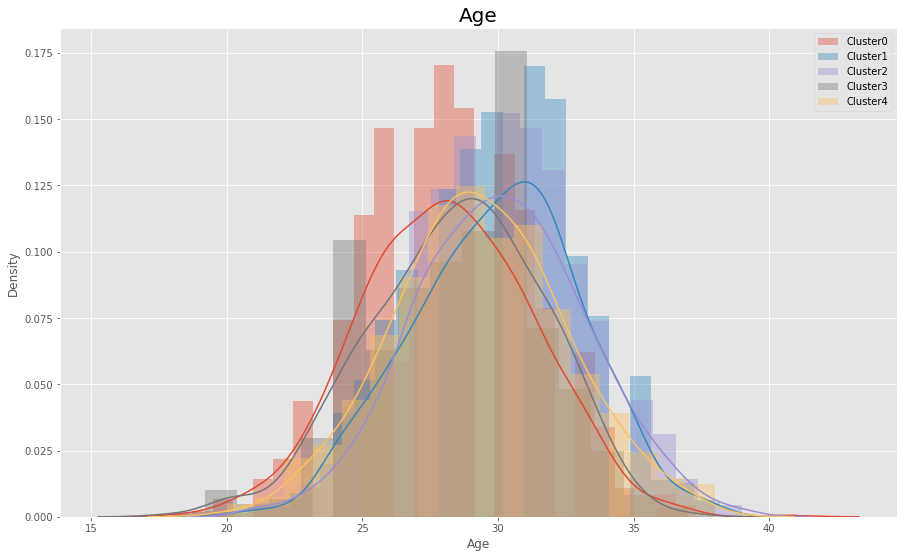

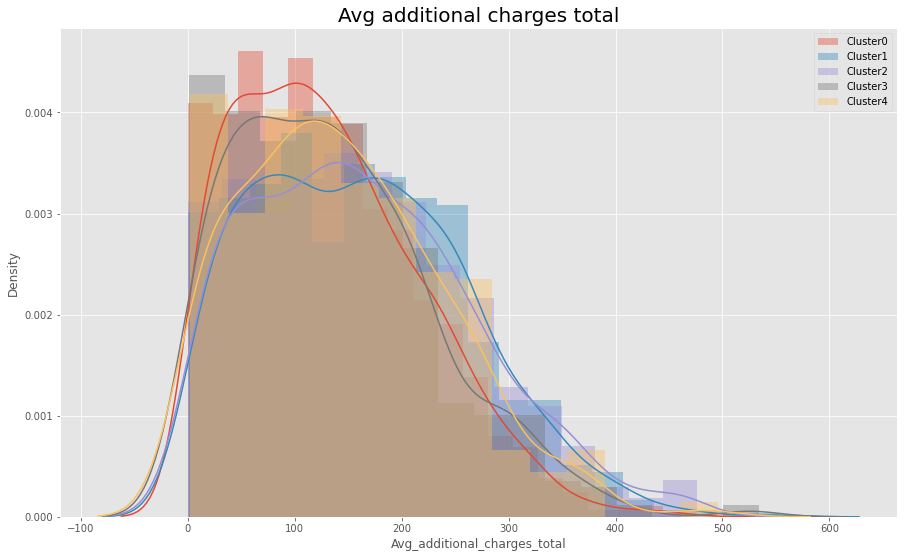

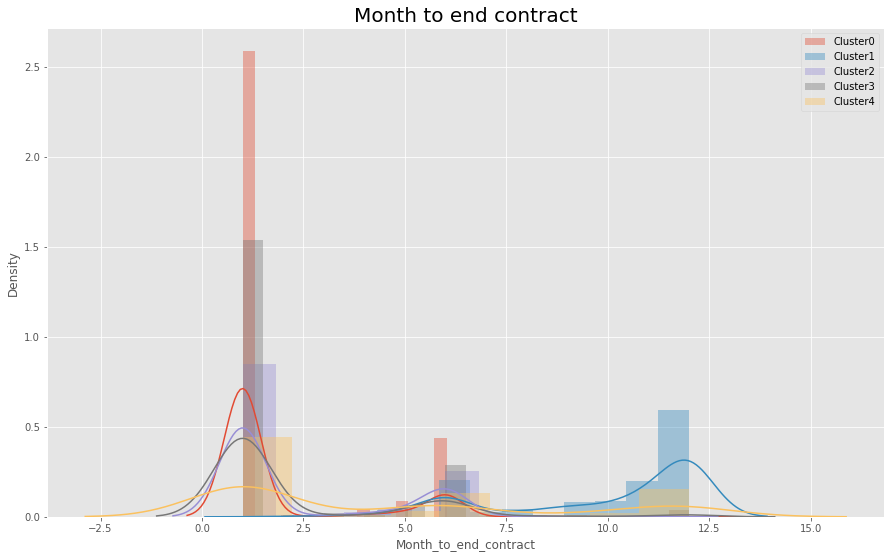

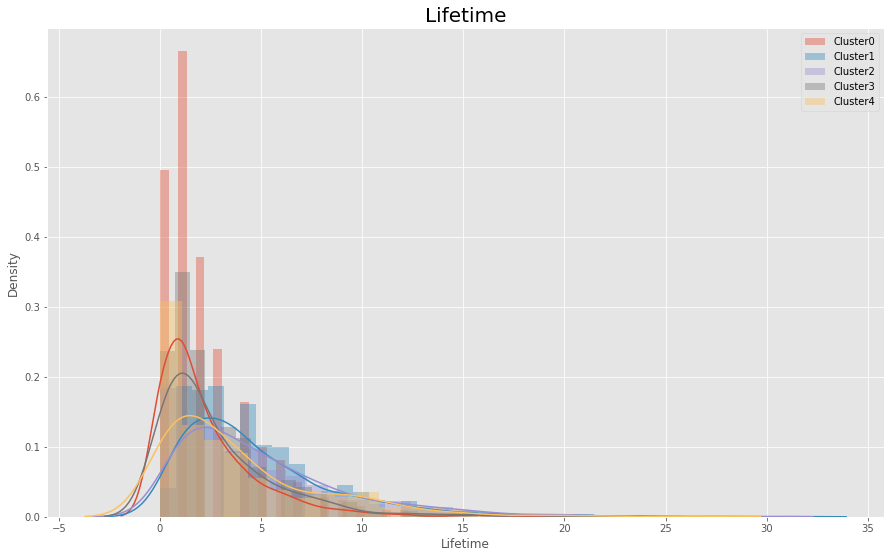

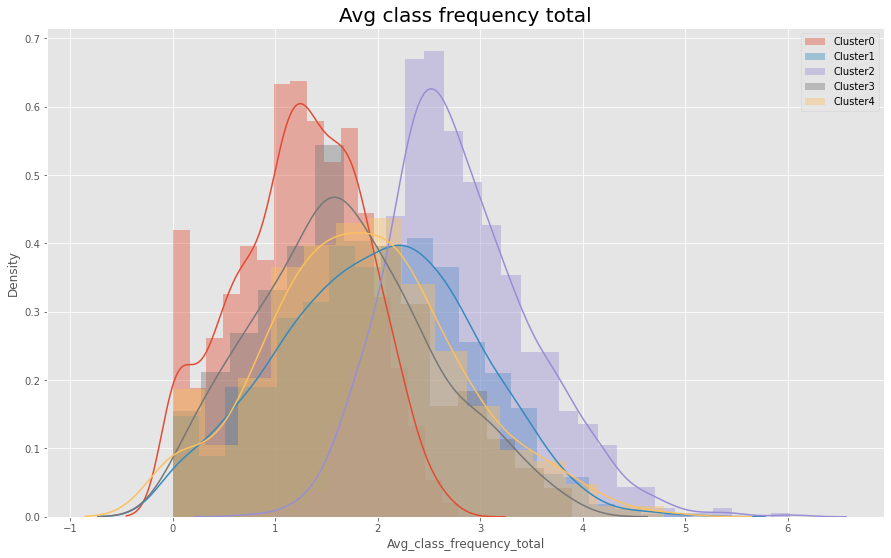

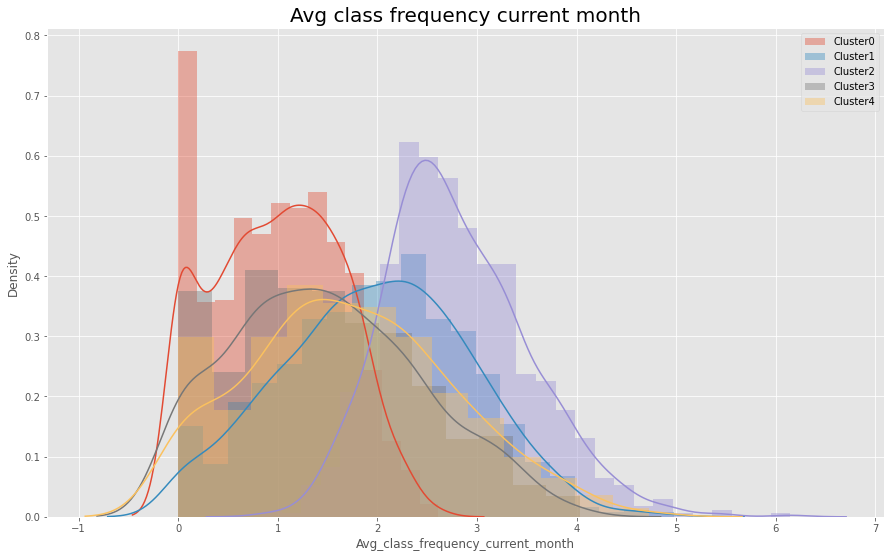

In [100]:
numeric_data= cluster_data[cluster_data.columns[cluster_data.max()>1]]
            
for j in range (0,len(numeric_data.drop('cluster_km', axis= 1).columns)):
    colname= list(numeric_data.columns)[j+1]
    if colname != 'cluster_km':
        fig, ax= plt.subplots(figsize= (15,9))
        for i in range(0,5):
            subset= numeric_data.query('cluster_km == @i')
            rel= subset[colname]
            ax= sns.distplot(rel, label='Cluster' +str(i))
        ax.legend()
        ax.set_title(colname.replace('_',' '), size= 20)
        plt.show()
    #for col, data in subset.iteritems()

The histograms show that the distributions of cluster 0, next to having lower mean values, also seem to have a lower variance. Cluster 1 also has a lower variance. This reiterates the idea that these are our extreme user clusters which are crowded with customers who have very low/high values on all levels. In the next step, I'going to check whether we see relevant differences in churn rates between the different groups. 

#### Calculate the churn rate for each cluster (use the groupby() method). Do they differ in terms of churn rate? Which clusters are prone to leaving, and which are loyal?

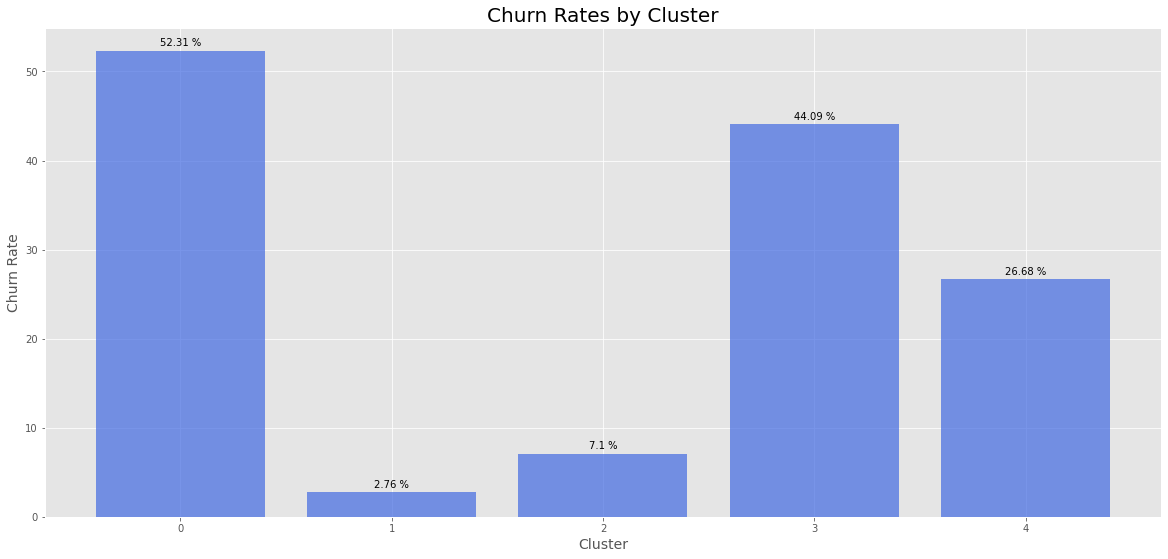

,cluster_km,Percent
1,0,0.523114
7,3,0.440945
9,4,0.266839
5,2,0.071013
3,1,0.027613


In [101]:
#cluster_data.groupby('cluster_km').mean().reset_index()

churn_data['cluster_km']= labels

churn_rates= churn_data.groupby(['cluster_km','Churn'])['Age'].count().reset_index()

churn_rates['Age']= churn_rates.groupby(['cluster_km'])['Age'].transform(lambda x: x/x.sum())

churn_rates= churn_rates.rename(columns= {'Age':'Percent'}).query('Churn== 1')[['cluster_km','Percent']]

churn_rates= churn_rates.sort_values('Percent', ascending= False)


fig, ax= plt.subplots(figsize= (20,9))

plot= ax.bar(churn_rates.cluster_km, np.round(churn_rates.Percent*100,2), color= 'royalblue', alpha= 0.7)

ax.set_title('Churn Rates by Cluster', size= 20)
ax.set_xlabel('Cluster', size= 14)
ax.set_ylabel('Churn Rate', size= 14)


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{} %'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(plot)
plt.show()
churn_rates
#.reset_index()#.rename(columns= {'Age':'Count'})

As we can see cluster 0 and 1 have the highest risk to churn while 1 and 2 have a very low risk. Cluster 4's churn rate represents the rate of the whole unclustered dataset. From our observations we should conclude that we should invest resources based on the churn rates in descending order.

## Come up with conclusions and basic recommendations on working with customers

Following from the analysis above three recommendations are made: 

1. Prioritise high risk user clusters 
2. Charge lower fees to younger users - for example up to 27 years. Young users are at a higher risk to churn which is likely due to lower financial capabilities. 
3. Find more cooperation partners 
4. Offer a higher variety of group visits 
5. Offer more flexible contract periods 

I hope the insights generated in this report will be of help for our business. 